In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from causalcgm.utils import cace_score, interventions_from_root, compute_pns_matrix, conditional_entropy_dag
import numpy as np
import os
from causalcgm.causalcgm import CausalCGM
from causalcgm.baselines import CBM, CEM, StandardE2E
import pytorch_lightning as pl
from causalcgm.dataloader import load_preprocessed_data
import torch

/Users/gabri/Desktop/USI/PhD/GitHub/CausalCGM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
seed_everything(0)

# Hyperparameters
embedding_size = 8
ce_size = 5
gamma = 1
results_dir = './results/dsprites'
index_perturb = 3
index_block = 1
lambda_cace_2 = 0.05
os.makedirs(results_dir, exist_ok=True)

Seed set to 0


In [3]:
# Load dataset
(x_train, c_train, y_train, 
 x_test, c_test, y_test, 
 dag_init, to_check, label_names)  = load_preprocessed_data(base_dir='./datasets/dsprites')
n = x_train.shape[0]
x_val = x_train[-int(n*0.2):]
c_val = c_train[-int(n*0.2):]
y_val = y_train[-int(n*0.2):]
x_train = x_train[:int(n*0.8)]
c_train = c_train[:int(n*0.8)]
y_train = y_train[:int(n*0.8)]
n_concepts = c_train.shape[1]
n_classes = y_train.shape[1]
s_train = torch.cat((c_train, y_train), dim=1)
s_val = torch.cat((c_val, y_val), dim=1)
s_test = torch.cat((c_test, y_test), dim=1)
train_loader = DataLoader(TensorDataset(x_train, s_train), batch_size=128, shuffle=True)
train_loader_cbm = DataLoader(TensorDataset(x_train, c_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, s_val), batch_size=128, shuffle=False)
val_loader_cbm = DataLoader(TensorDataset(x_val, c_val, y_val), batch_size=128, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test, s_test), batch_size=128, shuffle=False)
test_loader_cbm = DataLoader(TensorDataset(x_test, c_test, y_test), batch_size=128, shuffle=False)

# Other variables useful for model initialization
n_symbols = s_train.shape[1]
n_concepts = c_train.shape[1]
n_classes = y_train.shape[1]
tp_size = n_concepts*ce_size
    

In [4]:
model = CausalCGM(x_train.shape[1], embedding_size, n_concepts, n_classes, ce_size, gamma, 0, lambda_cace_2, probabilistic=False)

In [5]:
# Fix the graph structure
fix_graph = True
if fix_graph:
    model.concept_embedder.eq_model.fc1.weight = torch.nn.Parameter(dag_init, requires_grad=False)
    model.concept_embedder.eq_model.edges_to_check = to_check
else:
    cov = conditional_entropy_dag(s_train)
    cov = torch.tensor(cov).float()
    cov[-1, :] = 0
    cov = torch.clamp((cov / cov.mean()), 0, 0.99)
    model.concept_embedder.eq_model.fc1.weight = torch.nn.Parameter(cov, requires_grad=True)


In [7]:
# train the model
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_concept_accuracy", mode="max", save_weights_only=True)
trainer = Trainer(max_epochs=200, accelerator='cpu', enable_checkpointing=True, callbacks=checkpoint_callback)
trainer.fit(model, train_loader_cbm, val_loader_cbm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gabri/Desktop/USI/PhD/GitHub/CausalCGM/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Missing logger folder: /Users/gabri/Desktop/USI/PhD/GitHub/CausalCGM/lightning_logs

  | Name             | Type                    | Params
-------------------------------------------------------------
0 | encoder          | Sequential              | 4.2 K 
1 | concept_embedder | CausalConceptGraphLayer | 4.6 K 
2 | loss             | BCELoss                 | 0     
3 | mse_loss         | MSELoss                 | 0     
-------------------------------------------------------------
8.8 K     Trainable params
36        Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)


/Users/gabri/Desktop/USI/PhD/GitHub/CausalCGM/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/gabri/Desktop/USI/PhD/GitHub/CausalCGM/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/gabri/Desktop/USI/PhD/GitHub/CausalCGM/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 199: 100%|██████████| 17/17 [00:00<00:00, 80.80it/s, v_num=0, val_loss=0.018, val_concept_accuracy=0.996, loss=0.506, dag=0.000, cace=0.557, c acc pri=1.000, c acc pos=0.138, y acc pri=1.000, y acc pos=1.000]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 17/17 [00:00<00:00, 80.09it/s, v_num=0, val_loss=0.018, val_concept_accuracy=0.996, loss=0.506, dag=0.000, cace=0.557, c acc pri=1.000, c acc pos=0.138, y acc pri=1.000, y acc pos=1.000]


In [8]:
# validate the model
model.load_state_dict(torch.load(checkpoint_callback.best_model_path)['state_dict'])
model.eval()

CausalCGM(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
  (concept_embedder): CausalConceptGraphLayer(
    (eq_model): CausalLayer(
      (fc1): Linear(in_features=6, out_features=6, bias=False)
      (fc2): ModuleList(
        (0): Linear(in_features=8, out_features=16, bias=False)
      )
    )
    (concept_context_generators): ModuleList(
      (0-5): 6 x Sequential(
        (0): Linear(in_features=8, out_features=16, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=16, out_features=16, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (concept_prob_predictor): ModuleList(
      (0-5): 6 x Sequential(
        (0): Linear(in_features=16, out_features=8, bias=True)
        (1): LeakyReLU(n

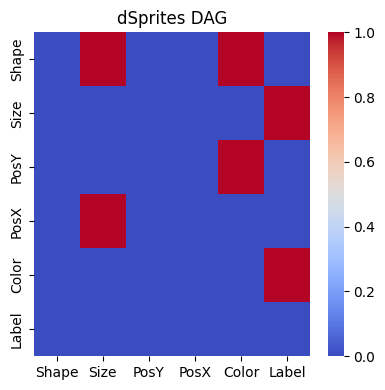

In [9]:
# show the DAG
model.concept_embedder.compute_parent_indices()
dag = model.concept_embedder.dag
# dag = model.concept_embedder.eq_model.fc1_to_adj().detach().cpu().numpy()
plt.figure(figsize=(4, 4))
plt.title(f'dSprites DAG')
dag_tmp = (dag > 0.01).astype(float)
sns.heatmap(dag_tmp, xticklabels=label_names, yticklabels=label_names, cmap='coolwarm', cbar=True, vmin=0, vmax=1)
plt.tight_layout()

In [10]:
# ATTENTION HERE, you need to change the index_perturb and index_block according to the discovered graph (3 and 0 works for the ground truth DAG)
# index_perturb = 3 # should be all parents of the index block
# index_block = 0 # should be the index of the children of the index perturb and should be an ancestor of the label

In [11]:
# data we need to test models
c_test = s_test[:, :-1].clone()
y_test = s_test[:, -1]
s_fake_1 = s_test.clone()
s_fake_0 = s_test.clone()
s_fake_1[:, [index_perturb]] = 1
s_fake_0[:, [index_perturb]] = 0
c_fake_1 = s_fake_1[:, :-1]
c_fake_0 = s_fake_0[:, :-1]
s_perturb = s_test.clone()
s_perturb[:, [index_perturb]] = 1 - s_test[:, [index_perturb]]
c_perturb = s_perturb[:, :-1]

In [12]:
# Causal Analysis - blocking dependencies
emb = model.encoder(x_train)

# compute standard accuracy
# do interventions without blocking
s_pred_c1 = model.forward(x_test, c=s_fake_1, intervention_idxs=[index_perturb])
s_pred_c0 = model.forward(x_test, c=s_fake_0, intervention_idxs=[index_perturb])

# do interventions with blocking
s_pred_c1_block = model.forward(x_test, c=s_fake_1, intervention_idxs=[index_perturb, index_block])
s_pred_c0_block = model.forward(x_test, c=s_fake_0, intervention_idxs=[index_perturb, index_block])

# do perturbation without blocking
s_pred_perturb = model.forward(x_test, c=s_perturb, intervention_idxs=[index_perturb])

# do perturbation with blocking
s_pred_perturb_block = model.forward(x_test, c=s_perturb, intervention_idxs=[index_perturb, index_block])


s_pred = model.forward(x_test)

In [13]:
# Causal Analysis - PNS
PNS = compute_pns_matrix(x_test, model, dag)

In [14]:
# interventions
acc_int = interventions_from_root(torch.tensor(dag), model, x_test, s_test, exclude=[n_concepts])

In [15]:
acc_int

([0.019696969696969657,
  0.040909090909090895,
  0.13560606060606062,
  0.12878787878787878],
 [0.5891414141414142,
  0.6676767676767676,
  0.7512626262626263,
  0.8580808080808081,
  0.907070707070707])

In [16]:
# metrics
s_accuracy = accuracy_score(s_test.ravel(), s_pred.ravel() > 0.5)
print(f'Label accuracy: {s_accuracy}')

cace = cace_score(s_pred_c1[:, -1], s_pred_c0[:, -1]).detach().item()
cace_block = cace_score(s_pred_c1_block[:, -1], s_pred_c0_block[:, -1]).detach().item()
print(f'CACE before blocking: {cace}')
print(f'CACE after blocking: {cace_block}')

Label accuracy: 0.9929292929292929
CACE before blocking: 0.4382691979408264
CACE after blocking: 0.0
